In [1]:
from pymongo import MongoClient
# MongoDB 연결
client = MongoClient('mongodb://192.168.0.50:27017/')
db_name = client["DB_SGMN"]
collection = db_name["COL_SCRAPPING_TOSS_COMMENT_HISTORY"]

In [2]:
# MongoDB에서 데이터 가져오기
data = list(collection.find())

import pandas as pd
# DataFrame으로 변환
df = pd.DataFrame(data)


In [3]:
# 날짜 데이터를 주 단위로 변환
df['week'] = pd.to_datetime(df['DATE']).dt.isocalendar().week

# 주 단위로 텍스트 데이터를 결합
grouped = df.groupby('week')['COMMENT'].apply(' '.join).reset_index()

In [4]:
from konlpy.tag import Okt
from sklearn.feature_extraction.text import TfidfVectorizer
import matplotlib.pyplot as plt
from wordcloud import WordCloud

/usr/local/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 51452 (\N{HANGUL SYLLABLE JU}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 44592 (\N{HANGUL SYLLABLE GI}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 48152 (\N{HANGUL SYLLABLE BAN}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 46041 (\N{HANGUL SYLLABLE DONG}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 49324 (\N{HANGUL SYLLABLE SA}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/lo

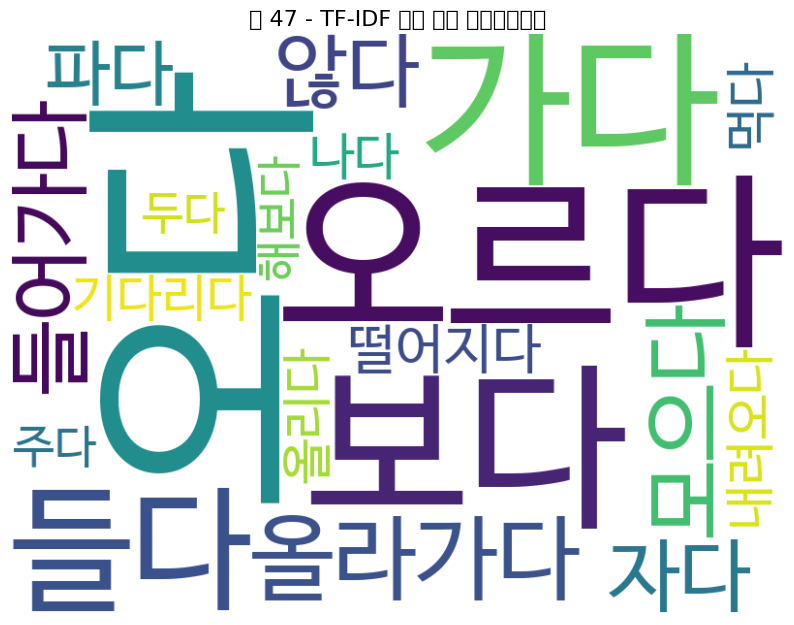

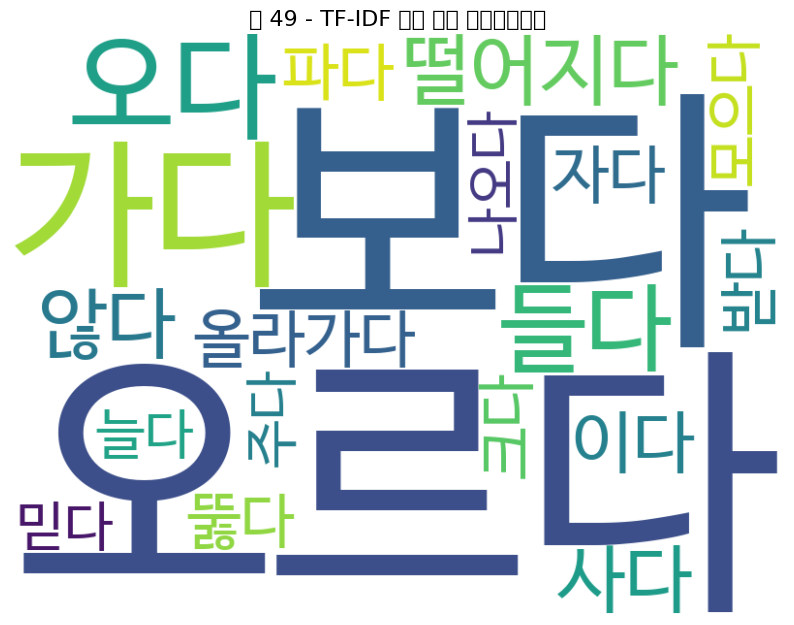

In [ ]:
 # Okt 객체 생성
okt = Okt()

# Okt 객체 생성
okt = Okt()

# 주 단위 데이터 반복 처리
for _, row in grouped.iterrows():
    week_text = row['COMMENT']  # 주 단위 텍스트 데이터
    week = row['week']  # 해당 주 번호
    
    # 품사 태깅
    pos_tags = okt.pos(week_text, norm=True, stem=True)  # 태깅 (normalize 및 어간 추출 옵션 추가)
    
    # 명사만 필터링
    verbs = [word for word, tag in pos_tags if tag == 'Verb']  # 'Noun' 태그 필터
    
    # 명사가 없다면 건너뜀
    if not verbs:
        print(f"주 {week}에는 명사가 없습니다.")
        continue
    
    # 명사를 하나의 문자열로 합침
    verb_text = ' '.join(verbs)
    
    # TF-IDF 벡터화
    vectorizer = TfidfVectorizer(
        max_features=20,  # 상위 20개 키워드만 추출
        stop_words=['하다', '되다', '있다', '없다', '되다'],  # 동사 불용어 설정
    )
    tfidf_matrix = vectorizer.fit_transform([verb_text])  # 텍스트를 리스트로 감쌈
    words = vectorizer.get_feature_names_out()
    scores = tfidf_matrix.toarray().flatten()
    
    # 단어와 점수를 딕셔너리 형태로 변환
    tfidf_scores = dict(zip(words, scores))
    
    # 워드클라우드 생성
    wordcloud = WordCloud(
        font_path='/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf',  # 한글 폰트 설정
        background_color='white',
        width=800,
        height=600
    ).generate_from_frequencies(tfidf_scores)
    
    # 워드클라우드 출력
    plt.figure(figsize=(10, 8))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(f'주 {week} - TF-IDF 기반 동사 워드클라우드', fontsize=16)
    plt.show()